In [18]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import Lattice2D, compass_to_surface, pauli2vector
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
from pymatching import Matching

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""pick the compass code"""
dim = 3
lat = Lattice2D(dim, dim)

coloring = np.random.randint(-1, 2, size=(dim-1)**2)
lat.color_lattice(coloring)
print(lat)

000---001---002
 |  ░  |  ░  |
003---004---005
 |     |  ▓  |
006---007---008



### Scheme for Decoder Graph (Code Capacity Model)
* Given a surface density code (a type of CSS code), we can construct decoder graphs for both $X$ and $Z$-type stabilizers
* Each vertex of the graph corresponds to a stabilizer and each edge corresponds to a qubit
    * In this scheme, if a qubit is involved in more than 2 stabilizer checks, then we can have a hyper-edge.

In [3]:
def get_parity_check_mat(stabs: List, stab_type: str):
    """
    Define parity check matrix for 'stabs' of 'stab_type' 

    Params:
    * stabs - List of stabilizers in string form where 'X' denotes X, 'Z' denotes Z and '_' denotes I
    * stab_type - Either 'X' or 'Z' as these are CSS codes
    """
    pc_mat = np.zeros((len(stabs), len(stabs[0])), dtype=int)
    for i, stab in enumerate(stabs):
        pc_mat[i] = np.array([1 * (lambda x : x == stab_type)(x) for x in stab])

    return pc_mat


In [4]:
pc_mat_X = get_parity_check_mat(lat.getSx(), stab_type='X')
pc_mat_Z = get_parity_check_mat(lat.getSz(), stab_type='Z')

In [5]:
def construct_decoder_graph_weighted(pc_mat : np.array, weights : np.array, num_rounds: int = 1):
    decode_graph = nx.MultiGraph()
    color_map = []

    for k in range(num_rounds):
        curr_decode_graph = nx.MultiGraph()
        for i, stab in enumerate(pc_mat):
            curr_decode_graph.add_node(str(i) + "," + str(k))

        for j, qubit in enumerate(pc_mat.T):
            stabs = [str(i) + "," + str(k) for i in range(len(qubit)) if qubit[i] == 1]
            if (len(stabs) == 1):
                stabs = tuple(stabs + ['B' + "," + str(k)])
                curr_decode_graph.add_edge(*stabs, weight=weights[j])
            else:
                curr_decode_graph.add_edge(*tuple(stabs), weight=weights[j])

        for node in curr_decode_graph:
            if(str(node) == 'B' + "," + str(k)):
                color_map.append('tab:red')
            else:
                color_map.append('tab:blue')

        if (k > 0):
            for node in curr_decode_graph:
                decode_graph.add_edge(node[0] + "," + str(k), 
                                           node[0] + ',' + str(k - 1))
        decode_graph = nx.compose(decode_graph, curr_decode_graph)

    return decode_graph, color_map

def construct_decoder_graph(pc_mat : np.array, num_rounds: int = 1):
    decode_graph = nx.MultiGraph()
    color_map = []

    for k in range(num_rounds):
        curr_decode_graph = nx.MultiGraph()
        for i, stab in enumerate(pc_mat):
            curr_decode_graph.add_node(str(i) + "," + str(k))

        for j, qubit in enumerate(pc_mat.T):
            stabs = [str(i) + "," + str(k) for i in range(len(qubit)) if qubit[i] == 1]
            if (len(stabs) == 1):
                stabs = tuple(stabs + ['B' + "," + str(k)])
                curr_decode_graph.add_edge(*stabs)
            else:
                curr_decode_graph.add_edge(*tuple(stabs))

        for node in curr_decode_graph:
            if(str(node) == 'B' + "," + str(k)):
                color_map.append('tab:red')
            else:
                color_map.append('tab:blue')

        if (k > 0):
            for node in curr_decode_graph:
                decode_graph.add_edge(node[0] + "," + str(k), 
                                           node[0] + ',' + str(k - 1))
        decode_graph = nx.compose(decode_graph, curr_decode_graph)

    return decode_graph, color_map

In [6]:
decode_graph_X, color_map_X = construct_decoder_graph(pc_mat_X, num_rounds=1)
decode_graph_Z, color_map_Z = construct_decoder_graph(pc_mat_Z, num_rounds=1)

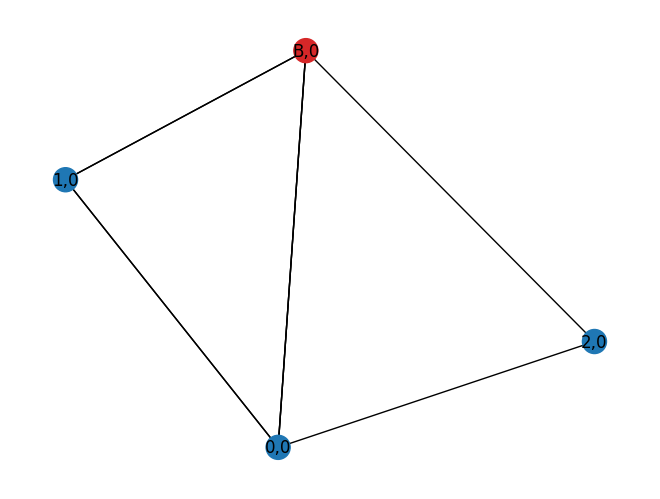

In [7]:
nx.draw(decode_graph_X, node_color = color_map_X, with_labels=True)

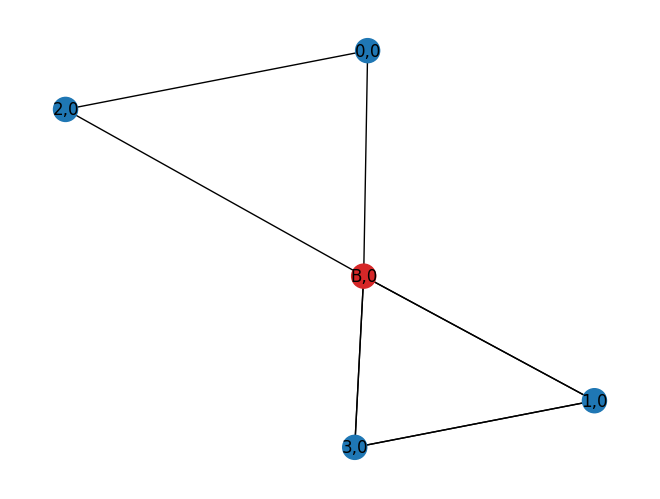

In [8]:
nx.draw(decode_graph_Z, node_color = color_map_Z, with_labels=True)

In [9]:
print("X PARITY CHECKk")
print(pc_mat_X)
print('\n')
print("Z PARITY CHECK")
print(pc_mat_Z)

X PARITY CHECKk
[[1 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 1 0 0 1]]


Z PARITY CHECK
[[1 1 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 1 1 0]
 [0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 1 1]]


In [10]:
nx.nx_agraph.write_dot(decode_graph_X, "decoder_graph_files/decode_graph_X.dot")
!neato -T png "decoder_graph_files/decode_graph_X.dot" > "decoder_graph_files/decode_graph_X.png"

nx.nx_agraph.write_dot(decode_graph_Z, "decoder_graph_files/decode_graph_Z.dot")
!neato -T png "decoder_graph_files/decode_graph_Z.dot" > "decoder_graph_files/decode_graph_Z.png"

# Error Correction Loop
1. Prepare in computational basis state
2. Fix a simple noise model
3. Note error operator at given timestep
4. Perform syndrome measurement
5. MWPM decoder
6. Do you remain in computational basis state coset after applying operation?
7. Repeat
8. Calculate logical error rate

In [11]:
"""Sample a random Pauli error
    for now, I'll assume biased, symmetric, uncorrelated Pauli channel
"""
import random

def random_pauli(num_qubits : int, rates : list):
    assert rates[0] + rates[1] + rates[2] <= 1, "Error rate must not exceed 1"""
    paulis = []
    for i in range(num_qubits):
        x = random.uniform(0, 1)
        if x <= rates[0]: 
            paulis.append('X')
        elif x <= rates[0] + rates[1]:
            paulis.append('Y')
        elif x <= rates[0] + rates[1] + rates[2]:
            paulis.append('Z')
        else:
            paulis.append('_')
    return ''.join(paulis)

P = random_pauli(lat.size(), [0.01, 0.01, 0.01])
print(P)

_________


In [12]:
pauli2vector(P)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
"""get the syndrome of the pauli operator """

def twisted_product(stab_binary, pauli_binary):
    """
    take twisted product of stabilizer with pauli to calculate commutator 
    """
    
    if len(stab_binary.shape) == 1:
        # if we have only 1 stabilizer
        L = int(len(stab_binary)/2)
        return (stab_binary[:L]@pauli_binary[L:] + stab_binary[L:]@pauli_binary[:L]) % 2
    else:
        # if we have a parity check 
        L = int(stab_binary.shape[1]/2)
        assert stab_binary.shape[1] == len(pauli_binary)
        syndrome = []
        for i in range(stab_binary.shape[0]):
            syndrome.append((stab_binary[i, :L]@pauli_binary[L:] + stab_binary[i, L:]@pauli_binary[:L]) % 2)
        return np.array(syndrome)
syndromeZ = twisted_product(lat.pcheckX(), pauli2vector(P)) # Syndrome for Z errors
syndromeX = twisted_product(lat.pcheckZ(), pauli2vector(P)) # Syndrome for X errors
print(syndromeZ, syndromeX)

[0 0 0] [0 0 0 0]


In [14]:
"""setup datastructures for MWPM decoding"""

def pcheck_clipZ(pcheck):
    """
    clip (remove) the 1st half of the parity check matrix
    """
    L = int(pcheck.shape[1]/2)
    return pcheck[:, L:]

def pcheck_clipX(pcheck):
    """
    clip (remove) the 2nd half of the parity check matrix
    """
    L = int(pcheck.shape[1]/2)
    return pcheck[:, :L]

### BP-Matching

In [15]:
lat = Lattice2D(4, 4)

coloring = np.random.randint(-1, 2, size=(4-1)**2)
lat.color_lattice(coloring)
error_probability = 0.09
rates = [0.03, 0.03, 0.03]
pcheckX = lat.pcheckX() # X-type Pauli check matrix
pcheckZ = lat.pcheckZ() # Z-type Pauli check matrix
num_qubits = lat.size()
pcheck = np.vstack([pcheckX, pcheckZ])
Hz = pcheck_clipZ(pcheckZ) # Z-type check matrix for checking X-type errors
Hx = pcheck_clipX(pcheckX) # X-type check matrix for checking Z-type errors

In [16]:
# Single Round Test Run
import numpy as np
from ldpc import bposd_decoder

# BP decoder for X errors
bpd_X=bposd_decoder(
    Hz,#the parity check matrix
    error_rate=error_probability,
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=num_qubits, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=7 #the osd search depth
    )

# BP decoder for Z errors
bpd_Z=bposd_decoder(
    Hx,#the parity check matrix
    error_rate=error_probability,
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=num_qubits, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=7 #the osd search depth
    )

In [17]:
def undirected_decoder_graph(multi_graph : nx.Graph) -> nx.Graph:
    """ 
    Takes a multigraph with weighted edges and returns an undirected graph with same vertices and edge weights summed together

    Params:
    * graph - Input multigraph
    """
    G = nx.Graph
    for u, v, data in multi_graph.edges(data=True):
        w = data['weight'] if 'weight' in data else 0.0
        print(G.has_edge(u,v))
        if nx.has_edge(G,u,v):
            G[u][v]['weight'] += w 
        else:
            G.add_edge(u,v,weight=w)
    return G

In [21]:
P = random_pauli(lat.size(), rates)
while P == 'I'*lat.size():
    # resample if we got an identity error -- note this actually increases the error rate we measure
    P = random_pauli(lat.size(), rates)
error = pauli2vector(P)
print("ERROR: " + str(error))
syndromeZ = twisted_product(pcheckX, error) # Syndrome for Z error
print("X SYNDROME: " + str(syndromeZ))
syndromeX = twisted_product(pcheckZ, error) # Syndrome for X error
print("Z SYNDROME: " + str(syndromeX))
print("BP_X HARD DECISION: " + str(bpd_X.decode(syndromeX)))
bpd_X_soft_decision = bpd_X.log_prob_ratios # Soft decision for X error
print("BP_X SOFT DECISOIN: " + str(bpd_X.log_prob_ratios))
print("BP_Z HARD DECISION: " + str(bpd_Z.decode(syndromeZ)))
bpd_Z_soft_decision = bpd_Z.log_prob_ratios # Soft decision for Z error
print("BP_Z SOFT DECISION: " + str(bpd_Z.log_prob_ratios))
decoder_graph_X = Matching(Hx, spacelike_weights=bpd_Z_soft_decision)
decoder_graph_Z = Matching(Hz, spacelike_weights=bpd_X_soft_decision)
c_Z = decoder_graph_X.decode(syndromeZ)
c_X = decoder_graph_Z.decode(syndromeX)
print("Z Correction Operator: " + str(c_Z))
print("X Correction Operator: " + str(c_X))

ERROR: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
X SYNDROME: [0 1 0 0 0]
Z SYNDROME: [1 0 0 0 0 0]
BP_X HARD DECISION: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
BP_X SOFT DECISOIN: [4.62723456e+00 4.62730516e+00 4.62716395e+00 3.53032674e-05
 4.62723456e+00 4.62730516e+00 1.05908725e-04 3.53032674e-05
 4.62723456e+00 4.62730516e+00 1.05908725e-04 3.53032674e-05
 4.62723456e+00 4.62730516e+00 4.62716395e+00 3.53032674e-05]
BP_Z HARD DECISION: [0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
BP_Z SOFT DECISION: [ 2.78298221  2.78298221  2.78298221  2.78298221 -0.13925899 -0.13925899
 -0.13925899 -0.13925899  2.64368792 -0.13925899 -0.13925899  2.64368792
  1.84428764  2.78298221  2.78298221  1.84428764]
Z Correction Operator: [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
X Correction Operator: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [91]:
# # One Round Test

# P = random_pauli(lat.size(), rates)
# while P == 'I'*lat.size():
#     # resample if we got an identity error -- note this actually increases the error rate we measure
#     P = random_pauli(lat.size(), rates)
# error = pauli2vector(P)
# print("ERROR: " + str(error))
# syndromeZ = twisted_product(pcheckX, error) # Syndrome for Z error
# print("X SYNDROME: " + str(syndromeZ))
# syndromeX = twisted_product(pcheckZ, error) # Syndrome for X error
# print("Z SYNDROME: " + str(syndromeX))
# print("BP_X HARD DECISION: " + str(bpd_X.decode(syndromeX)))
# bpd_X_soft_decision = bpd_X.log_prob_ratios # Soft decision for X error
# print("BP_X SOFT DECISOIN: " + str(bpd_X.log_prob_ratios))
# print("BP_Z HARD DECISION: " + str(bpd_Z.decode(syndromeZ)))
# bpd_Z_soft_decision = bpd_Z.log_prob_ratios # Soft decision for Z error
# print("BP_Z SOFT DECISION: " + str(bpd_Z.log_prob_ratios))
# # Decoder graph for X-type Pauli
# decoder_graph_X, color_map_X = construct_decoder_graph_weighted(Hx, bpd_Z_soft_decision, num_rounds=1)
# # Decoder graph for Z-type Pauli
# decoder_graph_Z, color_map_Z = construct_decoder_graph_weighted(Hz, bpd_X_soft_decision, num_rounds=1)
# nx.nx_agraph.write_dot(decoder_graph_X, "decoder_graph_files/decode_graph_X.dot")
# !neato -T png "decoder_graph_files/decode_graph_X.dot" > "decoder_graph_files/decode_graph_X.png"
# nx.nx_agraph.write_dot(decoder_graph_Z, "decoder_graph_files/decode_graph_Z.dot")
# !neato -T png "decoder_graph_files/decode_graph_Z.dot" > "decoder_graph_files/decode_graph_Z.png"

ERROR: [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
X SYNDROME: [0 0 0 0 1]
Z SYNDROME: [1 1 0 0 0]
BP_X HARD DECISION: [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
BP_X SOFT DECISOIN: [3.53032674e-05 1.05908725e-04 1.05908725e-04 3.53032674e-05
 3.53032674e-05 1.05908725e-04 1.05908725e-04 3.53032674e-05
 3.53032674e-05 1.05908725e-04 4.62730516e+00 4.62723456e+00
 3.53032674e-05 4.62716395e+00 4.62730516e+00 4.62723456e+00]
BP_Z HARD DECISION: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
BP_Z SOFT DECISION: [ 4.91647422  4.04886113  4.04886113 -0.28920437  4.91647422  4.91647422
  4.91647422  3.18124803  4.91647422  4.91647422  4.91647422  4.91647422
  4.04886113  4.04886113  4.04886113  4.04886113]


In [102]:
decoder_graph_Z_undir = undirected_decoder_graph(decoder_graph_Z)
decoder_graph_X_undir = undirected_decoder_graph(decoder_graph_X)
# nx.nx_agraph.write_dot(decoder_graph_X_undir, "decoder_graph_files/decode_graph_X_undir.dot")
# !neato -T png "decoder_graph_files/decode_graph_X.dot" > "decoder_graph_files/decode_graph_X_undir.png"
# nx.nx_agraph.write_dot(decoder_graph_Z_undir, "decoder_graph_files/decode_graph_Z_undir.dot")
# !neato -T png "decoder_graph_files/decode_graph_Z.dot" > "decoder_graph_files/decode_graph_Z_undir.png"
# X_matching = nx.min_weight_matching(decoder_graph_X_undir)
# Z_matching = nx.min_weight_matching(decoder_graph_Z_undir)


AttributeError: module networkx has no attribute add_nodes_from

In [70]:
X_matching

{('0,0', '2,0'), ('B,0', '1,0')}

In [71]:
Z_matching

{('0,0', '3,0'), ('2,0', '4,0'), ('B,0', '1,0')}

In [22]:
num_rounds = 2000

codespace_projection = [0]*num_rounds
logical_errors = [0]*num_rounds
uncorrected_logical_error_rate = [0]*num_rounds
count = 0
tot_time = 0
for r in tqdm(range(num_rounds)):
    start_time = time.time()
    P = random_pauli(lat.size(), rates)
    while P == 'I'*lat.size():
        # resample if we got an identity error -- note this actually increases the error rate we measure
        P = random_pauli(lat.size(), rates)
    error = pauli2vector(P)
    syndromeZ = twisted_product(pcheckX, error) # Syndrome for Z errors
    syndromeX = twisted_product(pcheckZ, error) # Syndrome for X errors
    bpd_X.decode(syndromeZ)
    bpd_X_soft_decision = bpd_X.log_prob_ratios
    bpd_Z.decode(syndromeX)
    bpd_Z_soft_decision = bpd_Z.log_prob_ratios
    decoder_graph_X = Matching(Hx, spacelike_weights=bpd_Z_soft_decision)
    decoder_graph_Z = Matching(Hz, spacelike_weights=bpd_X_soft_decision)
    c_Z = decoder_graph_X.decode(syndromeZ)
    c_X = decoder_graph_Z.decode(syndromeX)
    recovery = np.concatenate((c_Z, c_X))

    corrected_error = pauli2vector(P) + recovery % 2
    if sum(twisted_product(pcheck, corrected_error)) > 0:
        codespace_projection[r] = 1
    if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
        logical_errors[r] = 1
    if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
        uncorrected_logical_error_rate[r] = 1

    end_time = time.time()
    tot_time += end_time - start_time

  0%|          | 0/2000 [00:00<?, ?it/s]

ValueError: The input to the ldpc.bp_decoder.decode must be a syndrome (of length=6). The inputted vector has length=5. Valid formats are `np.ndarray` or `scipy.sparse.spmatrix`.

In [53]:
print('number of codespace projection failures', sum(codespace_projection))
print('logical error rate', sum(logical_errors)/len(logical_errors))
print('uncorrected error rate', sum(uncorrected_logical_error_rate)/len(uncorrected_logical_error_rate))
print('physical error rate', sum(rates))
print('average time per round', tot_time/num_rounds)

number of codespace projection failures 0
logical error rate 0.0205
uncorrected error rate 0.156
physical error rate 0.03
average time per round 7.651567459106445e-05
